In [1]:
%matplotlib inline

# Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_train_features = pd.read_csv('../hb_train_feature.csv')
df_test_features = pd.read_csv('../hb_test_feature.csv')
df_train_truth = pd.read_csv('../hb_train_truth.csv')

In [25]:
df_train_features.head()

,r11,r12,r13,r21,r22,r23,r31,r32,r33,c11,c12,c13,c21,c22,c23,c31,c32,c33
0,80.0,50.0,80.0,20.0,90.0,60.0,30.0,10.0,10.0,70.0,30.0,40.0,60.0,10.0,70.0,10.0,40.0,50.0
1,20.0,51.0,50.0,10.0,70.0,30.0,60.0,5.0,45.0,20.0,10.0,60.0,51.0,70.0,5.0,50.0,30.0,45.0
2,70.0,100.0,48.0,10.0,29.0,40.0,40.0,60.0,100.0,70.0,10.0,40.0,100.0,29.0,60.0,48.0,40.0,100.0
3,20.0,60.0,70.0,30.0,90.0,20.0,40.0,40.0,50.0,40.0,20.0,80.0,90.0,40.0,90.0,60.0,10.0,60.0
4,13.0,80.0,60.0,74.0,20.0,70.0,60.0,100.0,10.0,13.0,74.0,60.0,80.0,20.0,100.0,60.0,70.0,10.0


In [26]:
df_train_features.shape

(250, 18)

In [7]:
df_train_truth.head()

,f1,f2,f3,action
0,0.868421,0.078947,0.052632,1.0
1,0.300000,0.550000,0.150000,2.0
2,0.450000,0.000000,0.550000,3.0
3,0.421053,0.157895,0.421053,1.0
4,0.125000,0.550000,0.325000,2.0


In [15]:
df_train_features.iloc[0][9:]

c11    70.0
c12    30.0
c13    40.0
c21    60.0
c22    10.0
c23    70.0
c31    10.0
c32    40.0
c33    50.0
Name: 0, dtype: float64

In [19]:
pd.DataFrame(df_train_features.iloc[0][:9].reshape(3, 3), 
             index=['r1', 'r2', 'r3'], 
             columns=['c1', 'c2', 'c3'])

/Users/michael/anaconda3/envs/pyml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


,c1,c2,c3
r1,80.0,50.0,80.0
r2,20.0,90.0,60.0
r3,30.0,10.0,10.0


## Visualize game matrix better

In [59]:
def view_game_matrix(df_row):
    """
    View payoffs in 3x3 matrix format
    inputs
        df_row : Pandas series object, e.g. df.iloc[0]
    returns
        [row_payoffs, col_payoffs] : np.array (2x3x3)
    """
    return df_row.values.reshape(2, 3, 3)

In [60]:
view_game_matrix(df_train_features.iloc[0])

array([[[ 80.,  50.,  80.],
        [ 20.,  90.,  60.],
        [ 30.,  10.,  10.]],

       [[ 70.,  30.,  40.],
        [ 60.,  10.,  70.],
        [ 10.,  40.,  50.]]])

In [51]:
np.array(df_train_truth.iloc[0])

array([ 0.86842105,  0.07894737,  0.05263158,  1.        ])

## Distribution of plays

In aggregate this tends to 0, which is not that useful. However if we visualize by grouping / binning at similar payoffs maybe this could be better?

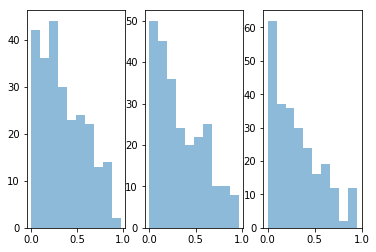

In [102]:
plt.subplot(1, 3, 1)
plt.hist(df_train_truth['f1'], alpha=0.5)
plt.subplot(1, 3, 2)
plt.hist(df_train_truth['f2'], alpha=0.5)
plt.subplot(1, 3, 3)
plt.hist(df_train_truth['f3'], alpha=0.5)
plt.show()

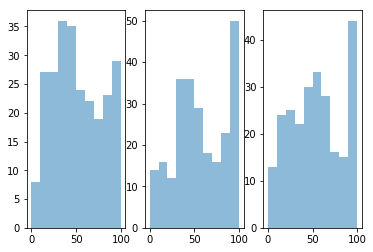

In [106]:
plt.subplot(1, 3, 1)
plt.hist(df_train_features['r11'], alpha=0.5)
plt.subplot(1, 3, 2)
plt.hist(df_train_features['r12'], alpha=0.5)
plt.subplot(1, 3, 3)
plt.hist(df_train_features['r13'], alpha=0.5)
plt.show()

## Game data processing and game similarity?

First preprocess data into list of 3x3 payoffs (row and column).  
Then for all payouts convert to $[0, 1]$ scale by normalizing (x - x_min / (x_max - x_min)).  
Then can do clustering to see what are the closest games by payout

In [110]:
def normalize(matrix):
    """
    Method to normalize a given matrix
    input:
        matrix : np.array, the payouts 
    output:
        np.array, the matrix normalized
    """
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)
    

### Construct new dataset format and normalize

In [240]:
def get_payoff_matrices(df, rows_first=False, normalized=True):
    """
    Convert input dataframe into new normed payoff data
    input:
        df : pandas.DataFrame
        rows_first : bool, if true, separate data into first row payoffs and then columns, 
        otherwise row and col payoffs lumped next to each other
        normalized : bool, if true, normalize the matrices
    output:
        np.array, the converted data 
    """
    if normalized:
        df = df.apply(normalize, axis=0)
    matrices = np.zeros([2 * df.shape[0], 3, 3])
    for row_ix in range(df.shape[0]):
        payoffs = view_game_matrix(df.iloc[row_ix])
        if rows_first:
            matrices[row_ix] = payoffs[0]
            matrices[row_ix + df.shape[0]] = payoffs[1]
        else:
            matrices[row_ix * 2] = payoffs[0]
            matrices[row_ix * 2 + 1] = payoffs[1]
#     if normalized:
#         matrices = np.array([normalize(matrices[ix]) for ix in range(matrices.shape[0])])
    return matrices

In [241]:
df_train_features.head(3)

,r11,r12,r13,r21,r22,r23,r31,r32,r33,c11,c12,c13,c21,c22,c23,c31,c32,c33
0,80.0,50.0,80.0,20.0,90.0,60.0,30.0,10.0,10.0,70.0,30.0,40.0,60.0,10.0,70.0,10.0,40.0,50.0
1,20.0,51.0,50.0,10.0,70.0,30.0,60.0,5.0,45.0,20.0,10.0,60.0,51.0,70.0,5.0,50.0,30.0,45.0
2,70.0,100.0,48.0,10.0,29.0,40.0,40.0,60.0,100.0,70.0,10.0,40.0,100.0,29.0,60.0,48.0,40.0,100.0


In [242]:
# all row payoffs then all col payoffs, unnormalized
norm_payoffs = get_payoff_matrices(df_train_features, rows_first=True, normalized=False)
norm_payoffs[:3]

array([[[  80.,   50.,   80.],
        [  20.,   90.,   60.],
        [  30.,   10.,   10.]],

       [[  20.,   51.,   50.],
        [  10.,   70.,   30.],
        [  60.,    5.,   45.]],

       [[  70.,  100.,   48.],
        [  10.,   29.,   40.],
        [  40.,   60.,  100.]]])

In [243]:
norm_payoffs = get_payoff_matrices(df_train_features, rows_first=True, normalized=True)
norm_payoffs[:3]

array([[[ 0.8 ,  0.5 ,  0.8 ],
        [ 0.2 ,  0.9 ,  0.6 ],
        [ 0.3 ,  0.1 ,  0.1 ]],

       [[ 0.2 ,  0.51,  0.5 ],
        [ 0.1 ,  0.7 ,  0.3 ],
        [ 0.6 ,  0.05,  0.45]],

       [[ 0.7 ,  1.  ,  0.48],
        [ 0.1 ,  0.29,  0.4 ],
        [ 0.4 ,  0.6 ,  1.  ]]])

In [161]:
norm_payoffs.shape

(500, 3, 3)

### Cluster data with K-means

In [244]:
from sklearn.cluster import KMeans

In [268]:
# n_clusters is kind of arbitrary here
kmeans = KMeans(n_clusters=8, ).fit(norm_payoffs.reshape(500, 9))
clustered_games_r = {}
clustered_games_c = {}
for ix in range(len(kmeans.labels_)):
    label = kmeans.labels_[ix]
    if ix < 250:
        if label in clustered_games_r:
            clustered_games_r[label].append((norm_payoffs[ix], ix))
        else:
            clustered_games_r[label] = [(norm_payoffs[ix], ix)]       
    else:
        if label in clustered_games_c:
            clustered_games_c[label].append((norm_payoffs[ix], ix - 250))
        else:
            clustered_games_c[label] = [(norm_payoffs[ix], ix - 250)]

#### Visualize what the row player played for each similar column player

In [ ]:
cluste

In [318]:
# df[df.index.isin(my_list)]
def plot_row_cow_clusters(ix):
    filtered_df_r = df_train_truth[df_train_truth.index.isin([r[1] for r in clustered_games_r[ix]])]
    filtered_df_c = df_train_truth[df_train_truth.index.isin([c[1] for c in clustered_games_c[ix]])]
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.hist(filtered_df_r['f1'], alpha=0.5)
    plt.hist(filtered_df_c['f1'], alpha=0.5)
    plt.xlim(-0.1, 1.1)
    plt.subplot(1, 3, 2)
    plt.hist(filtered_df_r['f2'], alpha=0.5)
    plt.hist(filtered_df_c['f2'], alpha=0.5)
    plt.xlim(-0.1, 1.1)
    plt.subplot(1, 3, 3)
    plt.hist(filtered_df_r['f3'], alpha=0.5)
    plt.hist(filtered_df_c['f3'], alpha=0.5)
    plt.xlim(-0.1, 1.1)
    plt.show()

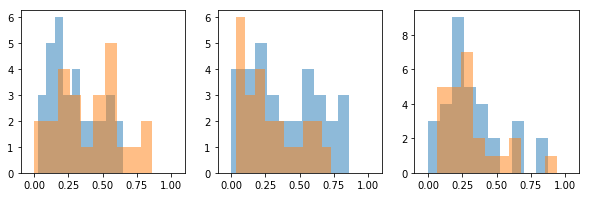

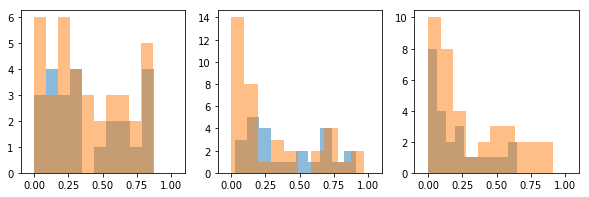

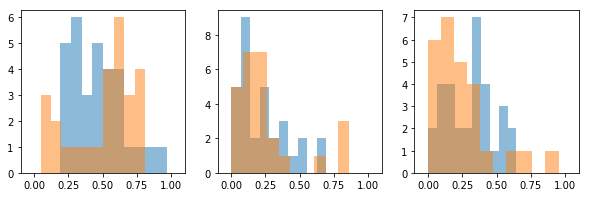

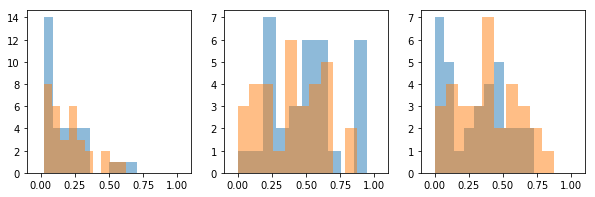

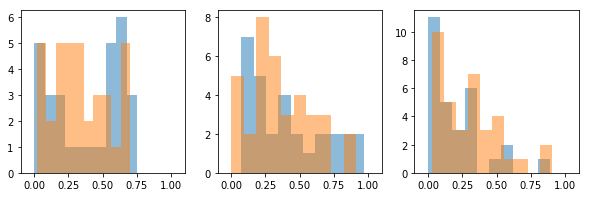

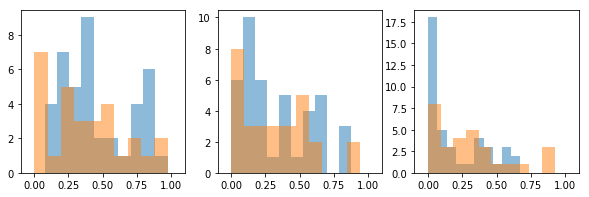

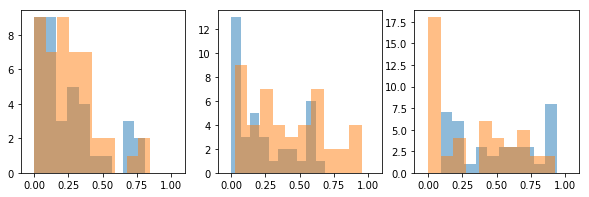

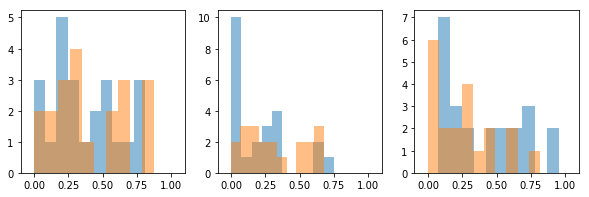

In [319]:
for i in range(8):
    plot_row_cow_clusters(i)

### Visualize with the help of PCA
Convert games to 2 dimensions first, then do clustering

In [248]:
from sklearn.decomposition import PCA

In [249]:
pca = PCA(n_components=2)
pca_payoffs = pca.fit_transform(norm_payoffs.reshape(500, 9))

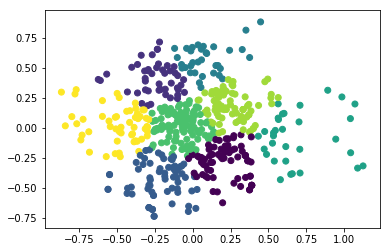

In [261]:
pca = PCA(n_components=2)
pca_payoffs = pca.fit_transform(norm_payoffs.reshape(500, 9))
# n_clusters is kind of arbitrary here
kmeans = KMeans(n_clusters=8, ).fit(pca_payoffs)
plt.scatter(x=pca_payoffs[:, 0], y=pca_payoffs[:, 1], c=kmeans.labels_, cmap='viridis')

In [250]:
pca_payoffs.shape

(500, 2)

In [217]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
norm_scaler = MinMaxScaler()
standard_scaler = StandardScaler() 

In [218]:
norm_scaler.fit_transform(df_train_features)

array([[ 0.8 ,  0.5 ,  0.8 , ...,  0.1 ,  0.4 ,  0.5 ],
       [ 0.2 ,  0.51,  0.5 , ...,  0.5 ,  0.3 ,  0.45],
       [ 0.7 ,  1.  ,  0.48, ...,  0.48,  0.4 ,  1.  ],
       ..., 
       [ 0.79,  0.51,  0.55, ...,  0.55,  0.99,  0.19],
       [ 0.7 ,  0.8 ,  0.4 , ...,  0.4 ,  0.93,  0.6 ],
       [ 0.4 ,  0.35,  0.05, ...,  0.05,  0.51,  0.7 ]])

In [219]:
standard_scaler.fit_transform(df_train_features)

array([[ 1.14560024, -0.12009153,  0.98975857, ..., -1.42172677,
        -0.23688418,  0.025155  ],
       [-1.00778367, -0.08624386, -0.02171292, ..., -0.03616321,
        -0.59776807, -0.14209897],
       [ 0.78670292,  1.57229195, -0.08914435, ..., -0.10544139,
        -0.23688418,  1.6976947 ],
       ..., 
       [ 1.10971051, -0.08624386,  0.14686566, ...,  0.13703224,
         1.89233074, -1.01181962],
       [ 0.78670292,  0.89533856, -0.35887009, ..., -0.3825541 ,
         1.67580041,  0.35966294],
       [-0.28998903, -0.62780658, -1.53892016, ..., -1.59492221,
         0.16008809,  0.69417088]])

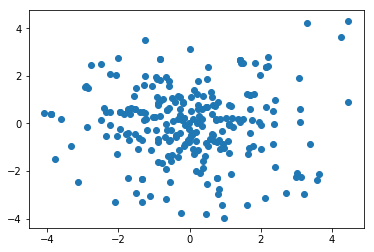

In [220]:
normed_df = standard_scaler.fit_transform(df_train_features) # df_train_features.apply(normalize, axis=0)
pca = PCA(n_components=2)
pca_payoffs = pca.fit_transform(normed_df)
plt.scatter(x=pca_payoffs[:, 0], y=pca_payoffs[:, 1])

In [255]:
normed_df

array([[ 0.8 ,  0.5 ,  0.8 , ...,  0.1 ,  0.4 ,  0.5 ],
       [ 0.2 ,  0.51,  0.5 , ...,  0.5 ,  0.3 ,  0.45],
       [ 0.7 ,  1.  ,  0.48, ...,  0.48,  0.4 ,  1.  ],
       ..., 
       [ 0.79,  0.51,  0.55, ...,  0.55,  0.99,  0.19],
       [ 0.7 ,  0.8 ,  0.4 , ...,  0.4 ,  0.93,  0.6 ],
       [ 0.4 ,  0.35,  0.05, ...,  0.05,  0.51,  0.7 ]])

In [257]:
norm_payoffs.reshape(500, 9)

array([[ 0.8 ,  0.5 ,  0.8 , ...,  0.3 ,  0.1 ,  0.1 ],
       [ 0.2 ,  0.51,  0.5 , ...,  0.6 ,  0.05,  0.45],
       [ 0.7 ,  1.  ,  0.48, ...,  0.4 ,  0.6 ,  1.  ],
       ..., 
       [ 0.79,  0.59,  0.59, ...,  0.55,  0.99,  0.19],
       [ 0.7 ,  0.1 ,  0.88, ...,  0.4 ,  0.93,  0.6 ],
       [ 0.4 ,  0.3 ,  0.4 , ...,  0.05,  0.51,  0.7 ]])

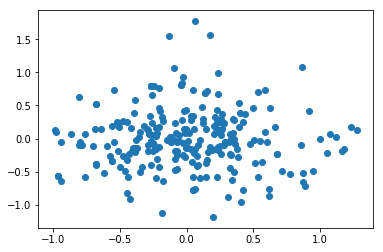

In [253]:
normed_df = norm_scaler.fit_transform(df_train_features) # df_train_features.apply(normalize, axis=0)
pca = PCA(n_components=2)
pca_payoffs = pca.fit_transform(normed_df)
plt.scatter(x=pca_payoffs[:, 0], y=pca_payoffs[:, 1])

## Idea 1: Convolutions

If the players see a bimatrix game in the matrix format (even if they don't), then they might pick actions based on some saliency to the payoffs. We can then think of how we would want to classify a payoff. 

They may consider their own payoffs, but also the payoffs of the opponent (several strategies involve trying to pick the same or trying to make the opponent well off too). So aside from their own payoffs we can have a matrix that shows the differences.

Would have a weight associated with each matrix item?

The frequency ground-truth is from the perspective of just the row player. However if we assume that the column player would play similarly, then we essentially have twice the data?  
* Row players in aggregate see some game output, and then picks actions with some frequency
* Column players in aggregate see some game input, and then picks actions with some frequency

Is there a way we can empirically try to see if this approach makes sense? Like identifying the most "similar" games from row and column perspectives, or if a column payout looks similar to a row payout, and seeing what the row payout played.

Can also consider making our own "features" as channels that represent different types of play. For example, the difference between row and column player outputs is one thing. Might be good to look at the different things considered in past literature (e.g. altruism or trying to do the same would mean it'd be good to look at the difference between the two)

Additionally, we can assume that the order of what's presented is invariant. 

In [62]:
# Example, the payoffs of a single game
payoff_game_0 = view_game_matrix(df_train_features.iloc[0])
print(payoff_game_0)

[[[ 80.  50.  80.]
  [ 20.  90.  60.]
  [ 30.  10.  10.]]

 [[ 70.  30.  40.]
  [ 60.  10.  70.]
  [ 10.  40.  50.]]]


In [63]:
# The differences of them
payoff_game_0[0] - payoff_game_0[1]

array([[ 10.,  20.,  40.],
       [-40.,  80., -10.],
       [ 20., -30., -40.]])

In [68]:
# Can also consider differences of the max
np.array([
    payoff_game_0[0] - np.max(payoff_game_0[0]),
    payoff_game_0[1] - np.max(payoff_game_0[1])])

array([[[-10., -40., -10.],
        [-70.,   0., -30.],
        [-60., -80., -80.]],

       [[  0., -40., -30.],
        [-10., -60.,   0.],
        [-60., -30., -20.]]])

In [69]:
df_train_truth.iloc[0]

f1        0.868421
f2        0.078947
f3        0.052632
action    1.000000
Name: 0, dtype: float64

In [74]:
def predict_max(df_row):
    payoff = view_game_matrix(df_row)
    payoff_diff = np.abs(payoff[0] - payoff[1])
    payoff_r_diff = payoff[0] - np.max(payoff[0])
    payoff_c_diff = payoff[1] - np.max(payoff[1])
    print(payoff_diff)
    print(payoff_r_diff)
    print(payoff_c_diff)


In [79]:
predict_max(df_train_features.iloc[3])

[[ 20.  40.  10.]
 [ 60.  50.  70.]
 [ 20.  30.  10.]]
[[-70. -30. -20.]
 [-60.   0. -70.]
 [-50. -50. -40.]]
[[-50. -70. -10.]
 [  0. -50.   0.]
 [-30. -80. -30.]]


In [80]:
df_train_truth.iloc[3]

f1        0.421053
f2        0.157895
f3        0.421053
action    1.000000
Name: 3, dtype: float64

## Idea 2: Generate more data

We don't have that many games (just 250?). But if we can learn the generate similar games then we could (1) predict the actual outcomes for different ones and (2) generate more training data to support a deep learning approach.


Could also try augmenting the data, e.g. "rotations" and also rotate the frequencies as well
* For this to be careful at first we want to establish a new mapping that is respected by both the row and column payoffs. E.g. 123 by 123 with game frequencys x, y, z becomes 312 by 312 and frequencies z, x, y

So we can augment our data by 3! = 6 times, such that we have 1500 datapoints in the training set.

In [323]:
df_train_features.head()

,r11,r12,r13,r21,r22,r23,r31,r32,r33,c11,c12,c13,c21,c22,c23,c31,c32,c33
0,80.0,50.0,80.0,20.0,90.0,60.0,30.0,10.0,10.0,70.0,30.0,40.0,60.0,10.0,70.0,10.0,40.0,50.0
1,20.0,51.0,50.0,10.0,70.0,30.0,60.0,5.0,45.0,20.0,10.0,60.0,51.0,70.0,5.0,50.0,30.0,45.0
2,70.0,100.0,48.0,10.0,29.0,40.0,40.0,60.0,100.0,70.0,10.0,40.0,100.0,29.0,60.0,48.0,40.0,100.0
3,20.0,60.0,70.0,30.0,90.0,20.0,40.0,40.0,50.0,40.0,20.0,80.0,90.0,40.0,90.0,60.0,10.0,60.0
4,13.0,80.0,60.0,74.0,20.0,70.0,60.0,100.0,10.0,13.0,74.0,60.0,80.0,20.0,100.0,60.0,70.0,10.0


In [324]:
norm_payoffs_r = norm_payoffs[:250]
norm_payoffs_c = norm_payoffs[250:]

In [350]:
def transform(payoffs, rotations):  # rotations = [2, 1, 0]
#     temp = norm_payoffs_c[:, 0]
    new_payoffs = np.zeros(payoffs.shape)
    for ix in range(len(rotations)):
        new_payoffs[:, ix] = payoffs[:, rotations[ix]]
    return new_payoffs

### Augment Data

In [362]:
import itertools
orderings = list(itertools.permutations([0, 1, 2]))

In [376]:
df_train_truth.values[:10]

array([[ 0.86842105,  0.07894737,  0.05263158,  1.        ],
       [ 0.3       ,  0.55      ,  0.15      ,  2.        ],
       [ 0.45      ,  0.        ,  0.55      ,  3.        ],
       [ 0.42105263,  0.15789474,  0.42105263,  1.        ],
       [ 0.125     ,  0.55      ,  0.325     ,  2.        ],
       [ 0.425     ,  0.3       ,  0.275     ,  1.        ],
       [ 0.28947368,  0.18421053,  0.52631579,  3.        ],
       [ 0.32432432,  0.54054054,  0.13513514,  2.        ],
       [ 0.125     ,  0.75      ,  0.125     ,  2.        ],
       [ 0.625     ,  0.25      ,  0.125     ,  1.        ]])

In [412]:
augmented_data = []
augmented_labels = []
for order in orderings:
    trans_payoffs_r = transform(norm_payoffs_r, order)
    trans_payoffs_c = transform(norm_payoffs_c, order)
    trans_freq = df_train_truth.apply(lambda x: x[list(order)], axis=1).values
    augmented_data.append(np.array([trans_payoffs_r, trans_payoffs_c]))
    augmented_labels.append(trans_freq)

In [408]:
augmented_data[0].shape

(2, 250, 3, 3)

In [433]:
df_train_features.head()

,r11,r12,r13,r21,r22,r23,r31,r32,r33,c11,c12,c13,c21,c22,c23,c31,c32,c33
0,80.0,50.0,80.0,20.0,90.0,60.0,30.0,10.0,10.0,70.0,30.0,40.0,60.0,10.0,70.0,10.0,40.0,50.0
1,20.0,51.0,50.0,10.0,70.0,30.0,60.0,5.0,45.0,20.0,10.0,60.0,51.0,70.0,5.0,50.0,30.0,45.0
2,70.0,100.0,48.0,10.0,29.0,40.0,40.0,60.0,100.0,70.0,10.0,40.0,100.0,29.0,60.0,48.0,40.0,100.0
3,20.0,60.0,70.0,30.0,90.0,20.0,40.0,40.0,50.0,40.0,20.0,80.0,90.0,40.0,90.0,60.0,10.0,60.0
4,13.0,80.0,60.0,74.0,20.0,70.0,60.0,100.0,10.0,13.0,74.0,60.0,80.0,20.0,100.0,60.0,70.0,10.0


In [454]:
np.array(augmented_data).transpose([0, 2, 1, 3, 4]).reshape(250 * 6, 2, 3, 3)[0]

array([[[ 0.8,  0.5,  0.8],
        [ 0.2,  0.9,  0.6],
        [ 0.3,  0.1,  0.1]],

       [[ 0.7,  0.3,  0.4],
        [ 0.6,  0.1,  0.7],
        [ 0.1,  0.4,  0.5]]])

In [415]:
augmented_data[1]

array([[[[ 0.8 ,  0.5 ,  0.8 ],
         [ 0.3 ,  0.1 ,  0.1 ],
         [ 0.2 ,  0.9 ,  0.6 ]],

        [[ 0.2 ,  0.51,  0.5 ],
         [ 0.6 ,  0.05,  0.45],
         [ 0.1 ,  0.7 ,  0.3 ]],

        [[ 0.7 ,  1.  ,  0.48],
         [ 0.4 ,  0.6 ,  1.  ],
         [ 0.1 ,  0.29,  0.4 ]],

        ..., 
        [[ 0.79,  0.51,  0.55],
         [ 0.59,  0.67,  0.19],
         [ 0.59,  0.31,  0.99]],

        [[ 0.7 ,  0.8 ,  0.4 ],
         [ 0.88,  0.3 ,  0.6 ],
         [ 0.1 ,  0.1 ,  0.93]],

        [[ 0.4 ,  0.35,  0.05],
         [ 0.4 ,  0.01,  0.7 ],
         [ 0.3 ,  0.4 ,  0.51]]],


       [[[ 0.7 ,  0.3 ,  0.4 ],
         [ 0.1 ,  0.4 ,  0.5 ],
         [ 0.6 ,  0.1 ,  0.7 ]],

        [[ 0.2 ,  0.1 ,  0.6 ],
         [ 0.5 ,  0.3 ,  0.45],
         [ 0.51,  0.7 ,  0.05]],

        [[ 0.7 ,  0.1 ,  0.4 ],
         [ 0.48,  0.4 ,  1.  ],
         [ 1.  ,  0.29,  0.6 ]],

        ..., 
        [[ 0.79,  0.59,  0.59],
         [ 0.55,  0.99,  0.19],
         [ 0.51,  0.31, 

In [427]:
df_train_features.head()

,r11,r12,r13,r21,r22,r23,r31,r32,r33,c11,c12,c13,c21,c22,c23,c31,c32,c33
0,80.0,50.0,80.0,20.0,90.0,60.0,30.0,10.0,10.0,70.0,30.0,40.0,60.0,10.0,70.0,10.0,40.0,50.0
1,20.0,51.0,50.0,10.0,70.0,30.0,60.0,5.0,45.0,20.0,10.0,60.0,51.0,70.0,5.0,50.0,30.0,45.0
2,70.0,100.0,48.0,10.0,29.0,40.0,40.0,60.0,100.0,70.0,10.0,40.0,100.0,29.0,60.0,48.0,40.0,100.0
3,20.0,60.0,70.0,30.0,90.0,20.0,40.0,40.0,50.0,40.0,20.0,80.0,90.0,40.0,90.0,60.0,10.0,60.0
4,13.0,80.0,60.0,74.0,20.0,70.0,60.0,100.0,10.0,13.0,74.0,60.0,80.0,20.0,100.0,60.0,70.0,10.0


In [430]:
augmented_data[0]).reshape([2, 6 * 250, 3, 3])[1]

array([[[ 0.2 ,  0.9 ,  0.6 ],
        [ 0.3 ,  0.1 ,  0.1 ],
        [ 0.8 ,  0.5 ,  0.8 ]],

       [[ 0.1 ,  0.7 ,  0.3 ],
        [ 0.6 ,  0.05,  0.45],
        [ 0.2 ,  0.51,  0.5 ]],

       [[ 0.1 ,  0.29,  0.4 ],
        [ 0.4 ,  0.6 ,  1.  ],
        [ 0.7 ,  1.  ,  0.48]],

       ..., 
       [[ 0.55,  0.99,  0.19],
        [ 0.51,  0.31,  0.67],
        [ 0.79,  0.59,  0.59]],

       [[ 0.4 ,  0.93,  0.6 ],
        [ 0.8 ,  0.1 ,  0.3 ],
        [ 0.7 ,  0.1 ,  0.88]],

       [[ 0.05,  0.51,  0.7 ],
        [ 0.35,  0.4 ,  0.01],
        [ 0.4 ,  0.3 ,  0.4 ]]])

In [423]:
np.array(augmented_labels).reshape([6 * 250, 3])

array([[ 0.86842105,  0.07894737,  0.05263158],
       [ 0.3       ,  0.55      ,  0.15      ],
       [ 0.45      ,  0.        ,  0.55      ],
       ..., 
       [ 0.05405405,  0.14864865,  0.7972973 ],
       [ 0.325     ,  0.1       ,  0.575     ],
       [ 0.525     ,  0.375     ,  0.1       ]])

In [369]:
augmented_data[0]

array([[[[ 0.8 ,  0.5 ,  0.8 ],
         [ 0.2 ,  0.9 ,  0.6 ],
         [ 0.3 ,  0.1 ,  0.1 ]],

        [[ 0.2 ,  0.51,  0.5 ],
         [ 0.1 ,  0.7 ,  0.3 ],
         [ 0.6 ,  0.05,  0.45]],

        [[ 0.7 ,  1.  ,  0.48],
         [ 0.1 ,  0.29,  0.4 ],
         [ 0.4 ,  0.6 ,  1.  ]],

        ..., 
        [[ 0.79,  0.51,  0.55],
         [ 0.59,  0.31,  0.99],
         [ 0.59,  0.67,  0.19]],

        [[ 0.7 ,  0.8 ,  0.4 ],
         [ 0.1 ,  0.1 ,  0.93],
         [ 0.88,  0.3 ,  0.6 ]],

        [[ 0.4 ,  0.35,  0.05],
         [ 0.3 ,  0.4 ,  0.51],
         [ 0.4 ,  0.01,  0.7 ]]],


       [[[ 0.7 ,  0.3 ,  0.4 ],
         [ 0.6 ,  0.1 ,  0.7 ],
         [ 0.1 ,  0.4 ,  0.5 ]],

        [[ 0.2 ,  0.1 ,  0.6 ],
         [ 0.51,  0.7 ,  0.05],
         [ 0.5 ,  0.3 ,  0.45]],

        [[ 0.7 ,  0.1 ,  0.4 ],
         [ 1.  ,  0.29,  0.6 ],
         [ 0.48,  0.4 ,  1.  ]],

        ..., 
        [[ 0.79,  0.59,  0.59],
         [ 0.51,  0.31,  0.67],
         [ 0.55,  0.99, 

In [368]:
augmented_data[1]

array([[[[ 0.8 ,  0.5 ,  0.8 ],
         [ 0.3 ,  0.1 ,  0.1 ],
         [ 0.2 ,  0.9 ,  0.6 ]],

        [[ 0.2 ,  0.51,  0.5 ],
         [ 0.6 ,  0.05,  0.45],
         [ 0.1 ,  0.7 ,  0.3 ]],

        [[ 0.7 ,  1.  ,  0.48],
         [ 0.4 ,  0.6 ,  1.  ],
         [ 0.1 ,  0.29,  0.4 ]],

        ..., 
        [[ 0.79,  0.51,  0.55],
         [ 0.59,  0.67,  0.19],
         [ 0.59,  0.31,  0.99]],

        [[ 0.7 ,  0.8 ,  0.4 ],
         [ 0.88,  0.3 ,  0.6 ],
         [ 0.1 ,  0.1 ,  0.93]],

        [[ 0.4 ,  0.35,  0.05],
         [ 0.4 ,  0.01,  0.7 ],
         [ 0.3 ,  0.4 ,  0.51]]],


       [[[ 0.7 ,  0.3 ,  0.4 ],
         [ 0.1 ,  0.4 ,  0.5 ],
         [ 0.6 ,  0.1 ,  0.7 ]],

        [[ 0.2 ,  0.1 ,  0.6 ],
         [ 0.5 ,  0.3 ,  0.45],
         [ 0.51,  0.7 ,  0.05]],

        [[ 0.7 ,  0.1 ,  0.4 ],
         [ 0.48,  0.4 ,  1.  ],
         [ 1.  ,  0.29,  0.6 ]],

        ..., 
        [[ 0.79,  0.59,  0.59],
         [ 0.55,  0.99,  0.19],
         [ 0.51,  0.31, 

In [353]:
norm_payoffs_r[:3]

array([[[ 0.8 ,  0.5 ,  0.8 ],
        [ 0.2 ,  0.9 ,  0.6 ],
        [ 0.3 ,  0.1 ,  0.1 ]],

       [[ 0.2 ,  0.51,  0.5 ],
        [ 0.1 ,  0.7 ,  0.3 ],
        [ 0.6 ,  0.05,  0.45]],

       [[ 0.7 ,  1.  ,  0.48],
        [ 0.1 ,  0.29,  0.4 ],
        [ 0.4 ,  0.6 ,  1.  ]]])

In [354]:
transform(norm_payoffs_r, [2, 1, 0])[:3]

array([[[ 0.3 ,  0.1 ,  0.1 ],
        [ 0.2 ,  0.9 ,  0.6 ],
        [ 0.8 ,  0.5 ,  0.8 ]],

       [[ 0.6 ,  0.05,  0.45],
        [ 0.1 ,  0.7 ,  0.3 ],
        [ 0.2 ,  0.51,  0.5 ]],

       [[ 0.4 ,  0.6 ,  1.  ],
        [ 0.1 ,  0.29,  0.4 ],
        [ 0.7 ,  1.  ,  0.48]]])

In [355]:
norm_payoffs_c[:3]

array([[[ 0.7 ,  0.3 ,  0.4 ],
        [ 0.6 ,  0.1 ,  0.7 ],
        [ 0.1 ,  0.4 ,  0.5 ]],

       [[ 0.2 ,  0.1 ,  0.6 ],
        [ 0.51,  0.7 ,  0.05],
        [ 0.5 ,  0.3 ,  0.45]],

       [[ 0.7 ,  0.1 ,  0.4 ],
        [ 1.  ,  0.29,  0.6 ],
        [ 0.48,  0.4 ,  1.  ]]])

In [356]:
transform(norm_payoffs_c, [2, 1, 0])[:3]

array([[[ 0.1 ,  0.4 ,  0.5 ],
        [ 0.6 ,  0.1 ,  0.7 ],
        [ 0.7 ,  0.3 ,  0.4 ]],

       [[ 0.5 ,  0.3 ,  0.45],
        [ 0.51,  0.7 ,  0.05],
        [ 0.2 ,  0.1 ,  0.6 ]],

       [[ 0.48,  0.4 ,  1.  ],
        [ 1.  ,  0.29,  0.6 ],
        [ 0.7 ,  0.1 ,  0.4 ]]])

### Data Augmentations

In [320]:
norm_payoffs

array([[[ 0.8 ,  0.5 ,  0.8 ],
        [ 0.2 ,  0.9 ,  0.6 ],
        [ 0.3 ,  0.1 ,  0.1 ]],

       [[ 0.2 ,  0.51,  0.5 ],
        [ 0.1 ,  0.7 ,  0.3 ],
        [ 0.6 ,  0.05,  0.45]],

       [[ 0.7 ,  1.  ,  0.48],
        [ 0.1 ,  0.29,  0.4 ],
        [ 0.4 ,  0.6 ,  1.  ]],

       ..., 
       [[ 0.79,  0.59,  0.59],
        [ 0.51,  0.31,  0.67],
        [ 0.55,  0.99,  0.19]],

       [[ 0.7 ,  0.1 ,  0.88],
        [ 0.8 ,  0.1 ,  0.3 ],
        [ 0.4 ,  0.93,  0.6 ]],

       [[ 0.4 ,  0.3 ,  0.4 ],
        [ 0.35,  0.4 ,  0.01],
        [ 0.05,  0.51,  0.7 ]]])

In [ ]:
## Load saved model (with hooks this time)
model_all_mse_s = ConvNetPdBig(softmax=True, dropout=0.5, channels=5)
model_all_mse_s.load_state_dict(torch.load('./model_all_mse_200.pt'))
model_all_mse_s.to(DEVICE)
model_all_mse_s.eval()